In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os 
import sys 

# TODO: may have to add '..' if move from root folder
home = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
pths = [os.path.join(home, 'astrobot')]

for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)

from astrobot.util import *

import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from pprint import pprint as pp 
# import pandas as pd 

# Tab after '.' to get all methods 
# Tab Shift after () to get documentation.
# To read excel data:
# pd.read_excel('afn_infil_data.xlsx')
# pd.read_clipboard()

# For experiments
# path to astrobot roo
ROOT_DIR

# path to this package from experiments folder
PACKAGE_FPATH_FOR_EXPERIMENTS

# path to epw from experiments folder
EPW_FPATH_FOR_EXPERIMENTS

'/mnt/c/Users/saeran2/master/git/astrobot/resources/epw/philadelphia/philadelphia.epw'

In [43]:
# Data entry 

df = pd.DataFrame(
    {
        'time':['2021/6/5 11:32', '6/5/2021 16:54', 
                '2021/6/6 4:50', '2021/6/6 11:19', '2021/6/6 16:21',
                '2021/6/7 3:02'],  
        'PC':[33, 30,
              19, 15, 70,
              30],  # 10^9 mg/L
        'Bags':[np.nan, 0,
                0, 0, 1,
                0]
    })

_N, N = df.shape[0], df.shape[0] - 1
df['time'] = pd.to_datetime(df['time'])
df['dh'] = np.ones(_N) * np.nan 
df.loc[1:, 'dh'] = \
    [(t2 - t1).seconds / 3600.0 
     for t1, t2 in zip(df.time[:-1], df.time[1:])]

# Fill with dummy vals 
df['C'] = np.ones(_N) * np.nan 
df['k'] = np.ones(_N) * np.nan
df['base'] = np.ones(_N) * np.nan

df

,time,PC,Bags,dh,C,k,base
0,2021-06-05 11:32:00,33,NaN,NaN,NaN,NaN,NaN
1,2021-06-05 16:54:00,30,0.0,5.366667,NaN,NaN,NaN
2,2021-06-06 04:50:00,19,0.0,11.933333,NaN,NaN,NaN
3,2021-06-06 11:19:00,15,0.0,6.483333,NaN,NaN,NaN
4,2021-06-06 16:21:00,70,1.0,5.033333,NaN,NaN,NaN
5,2021-06-07 03:02:00,30,0.0,10.683333,NaN,NaN,NaN


In [48]:
# TODO: Replace this with statistical calc 
# 1. Group data into binary no/yes blood bag 
# 2. Take log of PC for each group  
# 3. PC = (PC0 + PCb) e^-kT
# 4. log(PC) = log(PC0 + PCb) + -kt
# 5. y = B1 * t + B0 
#    e^B0 = PC0 + PCb; PCb = e^B0 - PC0
#    k = B1
# 6. Graph solved C e^-kt for no bag interval.  


def calc_PCb(bags):
    """
    Solve: platelets/L

    Q1: How many PC per L in bag
    Q2:  

    From ICU Dr:
    1 bag = 50,000 platelets
    
    Assume bag = 275 mL = 0.275 L 
    Assume she meant 50e9 not 50e3
    Assume human body has ~5L of blood. 
    
    50e9 PC / 5.0 L = 10e9 PC/L in body 

    # Reference: 
    330e9  # 300 ml Aphersis platelets
    55e9  # 50 ml whole blood-derived plateets 
    
    """
    # PC per liter in body from one bag  
    body_liters = 5.0
    pc_bag = 50e9
    pc = pc_bag / body_liters / 1e9
    fudge_factor = 5
    return bags * pc * fudge_factor 

# body_liters = 5.0
# pc_bag = 50e9
# pc = pc_bag / body_liters / 1e9
# pc    

In [49]:

# PC(t) = C e^-kt  
 
def calc_dt(hours):
    return hours * 60

def calc_C(PC0, PCb):
    return PC0 + PCb

def calc_k(PCt, C, dt):
    """
    PC(t) = C e^-kt
    ln(PC(t)) = ln(C) + ln(e) * -kt
    k = ln(PC(t)) - ln(C) / -t
    """
    return (np.log(PCt) - np.log(C)) / -dt 

def calc_PC(C, k, t):
    return C * np.e ** (-k * t)

# Calculate vars
_PC = df.PC.values
PC = _PC[1:]
dt = calc_dt(df['dh'].values)[1:]
PCb = calc_PCb(df['Bags'].values)[1:]
C = calc_C(_PC[:-1], PCb)  # offset so prior PC + current PC
k = calc_k(PC, C, dt)
base = np.e ** k 

# Update
df.loc[1:, 'dt'] = dt
df.loc[1:, 'PCb'] = PCb
df.loc[1:, 'C'] = C
df.loc[1:, 'k'] = k
df.loc[1:, 'base'] = base

df

,time,PC,Bags,dh,C,k,base,dt,PCb
0,2021-06-05 11:32:00,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-05 16:54:00,30,0.0,5.366667,33.0,0.000296,1.000296,322.0,0.0
2,2021-06-06 04:50:00,19,0.0,11.933333,30.0,0.000638,1.000638,716.0,0.0
3,2021-06-06 11:19:00,15,0.0,6.483333,19.0,0.000608,1.000608,389.0,0.0
4,2021-06-06 16:21:00,70,1.0,5.033333,65.0,-0.000245,0.999755,302.0,50.0
5,2021-06-07 03:02:00,30,0.0,10.683333,70.0,0.001322,1.001323,641.0,0.0


In [46]:
chkPC2 = calc_PC(C[-1], k[-1], dt[-1])
assert np.abs(chkPC2 - PC[-1]) < 1e-10, chkPC2

,PC,PCb,dh,time
0,33,NaN,NaN,2021-06-05 11:32:00
1,30,0.0,5.366667,2021-06-05 16:54:00
2,19,0.0,11.933333,2021-06-06 04:50:00
3,15,0.0,6.483333,2021-06-06 11:19:00
4,70,50.0,5.033333,2021-06-06 16:21:00
5,30,0.0,10.683333,2021-06-07 03:02:00


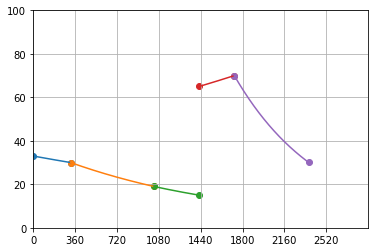

In [50]:
# plot decay
_, ax = plt.subplots(1, 1)
# ax = ax if isinstance(ax, np.ndarray) else [ax]
total_mins = 0
for i in range(N):
    mins = dt[i]
    tsteps = np.arange(mins)
    PCs = calc_PC(C[i], k[i], tsteps)
    
    # Update time step 
    tsteps += total_mins
    total_mins += mins
    
    ax.plot(tsteps, PCs)
    ax.scatter(tsteps[[0, -1]], PCs[[0, -1]])
    t1, t2 = df.loc[i, 'time'], df.loc[i+1, 'time']  
    hr = np.round((t2 - t1).seconds / 3600.0, 2)
plt.xlim([0, 12 * 60 * 4])
plt.xticks(np.arange(0, 12 * 60 * 4, 60 * 6))
plt.ylim([0, 100])
plt.grid()
df.loc[:, ['PC', 'PCb', 'dh', 'time']]


In [266]:
df

,time,PC,Bags,dh,C,k,base,dt,PCb
0,2021-06-05 11:32:00,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-05 16:54:00,30,0.0,5.366667,33.0,0.000296,1.000296,322.0,0.0
2,2021-06-06 04:50:00,19,0.0,11.933333,30.0,0.000638,1.000638,716.0,0.0
3,2021-06-06 11:19:00,15,0.0,6.483333,19.0,0.000608,1.000608,389.0,0.0
4,2021-06-06 16:21:00,70,1.0,5.033333,95.0,0.001011,1.001012,302.0,80.0


---Time---
                 time  PC         k
1 2021-06-05 16:54:00  30  0.000296
2 2021-06-06 04:50:00  19  0.000638
3 2021-06-06 11:19:00  15  0.000608
2    11.93
3     6.48
Name: dh, dtype: float64
Hrs 18.42
-----------

PC estimate: from 30 to 14, over 18.4 hours


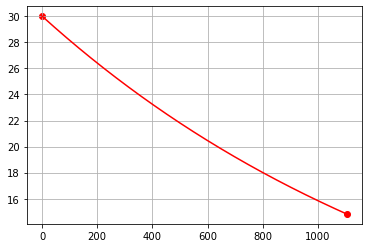

In [268]:
# Predict 
# which decay curve to predict from, and how many intervals
i, interval = 1, 2  

timeslice_ts = np.s_[i:i+interval]
timeslice_hr = np.s_[i+1:i+interval]
hr = np.sum(df.loc[timeslice_hr, 'dh'])  

print('---Time---')
print(df.loc[timeslice_ts, ['time', 'PC', 'k']])
print(df.loc[timeslice_hr, 'dh'].round(2))
print('Hrs', np.round(hr, 2))
print('-----------\n')

tsteps = np.arange(hr * 60)  # plot every minute 
PCs = calc_PC(C[i], k[i], tsteps)
print('PC estimate: from {} to {}, over {} hours'.format(
      int(PCs[0]), int(PCs[-1]), np.round(hr, 1)))
plt.plot(tsteps, PCs, 'red')
plt.scatter([tsteps[0], tsteps[-1]], [PCs[0], PCs[-1]], c='red')
#plt.xlim([0, hr * 60])
#plt.ylim([0, 50])
plt.grid()
